ДЗ к уроку 6.

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightgbm as lgbm
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
columns=['age', 
         'workclass',
         'fnlwgt', 
         'education', 
         'education-num',
         'marital-status', 
         'occupation', 
         'relationship', 
         'race', 
         'sex', 
         'capital-gain', 
         'capital-loss', 
         'hours-per-week', 
         'native-country',
         'target']
X_train = pd.read_csv("adult_data.csv")
X_train.columns = columns

y_train = pd.DataFrame()
y_train['target'] = X_train['target']

X_test = pd.read_csv("adult_test.csv")
X_test.columns = columns

y_test = pd.DataFrame()
y_test['target'] = X_test['target']

del X_test['target']
del X_train['target']

y_train.loc[y_train['target'] == ' <=50K', 'target'] = 0
y_train.loc[y_train['target'] == ' >50K', 'target'] = 1
y_test.loc[y_test['target'] == ' <=50K.', 'target'] = 0
y_test.loc[y_test['target'] == ' >50K.', 'target'] = 1

y_train['target'] = y_train['target'].astype('int')

print('Строк в трейне:' ,  X_train.shape[0])
print('Признаков в трейне:' ,  X_train.shape[1])
X_train.head(3)

Строк в трейне: 32560
Признаков в трейне: 14


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States


In [3]:
print('Строк в тесте:' ,  X_test.shape[0])
print('Признаков в тесте:' ,  X_test.shape[1])
X_test.head()

Строк в тесте: 16280
Признаков в тесте: 14


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


Feature engineering

1. Обработка пропусков

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-loss    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


Пропуски отсутствуют

2. Обработка выбросов

In [5]:
X_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


(array([  205.,   531.,   645.,  1547.,  1015.,  1302.,  1635., 16099.,
         2442.,   677.,  3036.,   841.,  1519.,   277.,   365.,    83.,
          182.,    20.,    34.,   105.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <a list of 20 Patch objects>)

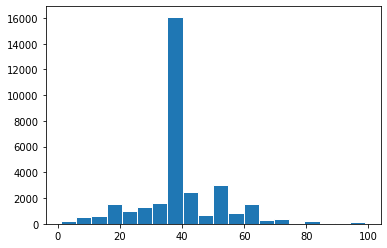

In [6]:
plt.hist(X_train['hours-per-week'],bins = 20, edgecolor = 'white')

(array([3.179e+04, 5.170e+02, 8.700e+01, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.590e+02]),
 array([    0. ,  9999.9, 19999.8, 29999.7, 39999.6, 49999.5, 59999.4,
        69999.3, 79999.2, 89999.1, 99999. ]),
 <a list of 10 Patch objects>)

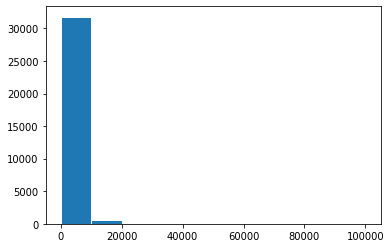

In [7]:
plt.hist(X_train['capital-gain'],bins = 10, edgecolor = 'white')

(array([3.1052e+04, 1.7000e+01, 2.1000e+01, 4.6100e+02, 7.7900e+02,
        2.0700e+02, 1.4000e+01, 0.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([   0. ,  435.6,  871.2, 1306.8, 1742.4, 2178. , 2613.6, 3049.2,
        3484.8, 3920.4, 4356. ]),
 <a list of 10 Patch objects>)

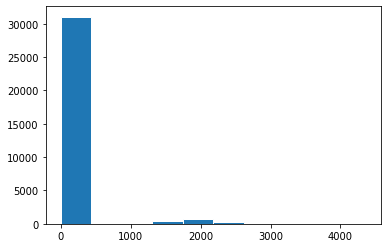

In [8]:
plt.hist(X_train['capital-loss'],bins = 10, edgecolor = 'white')

In [9]:
def FeatureCleaning(DataFrame):
    
    # обработка пропусков
    # - отсутствуют
    
    # обработка выбросов
    DataFrame.loc[DataFrame['hours-per-week'] > 80, 'hours-per-week'] = 80
    DataFrame.loc[DataFrame['capital-gain'] > 20000, 'capital-gain'] = 20000
    DataFrame.loc[DataFrame['capital-loss'] > 2500, 'capital-loss'] = 2500
        
    return DataFrame  

In [10]:
X_train = FeatureCleaning(X_train)
X_test = FeatureCleaning(X_test)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-loss    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [12]:
def FeatureEngineering(DataFrame):
    
    # Дамми переменные
    for cat_colname in DataFrame.select_dtypes(include='object').columns[0:]:
        DataFrame = pd.concat([DataFrame, pd.get_dummies(DataFrame[cat_colname], prefix=cat_colname)], axis=1)
    
    DataFrame = DataFrame.drop('workclass', axis=1)
    DataFrame = DataFrame.drop('education', axis=1)
    DataFrame = DataFrame.drop('marital-status', axis=1)
    DataFrame = DataFrame.drop('occupation', axis=1)
    DataFrame = DataFrame.drop('relationship', axis=1)
    DataFrame = DataFrame.drop('race', axis=1)
    DataFrame = DataFrame.drop('sex', axis=1)
    DataFrame = DataFrame.drop('native-country', axis=1)
    
    # Стандартизация данных
    NUM_FEATURE_NAMES = ['age',
                         'fnlwgt',
                         'education-num',
                         'capital-gain',
                         'capital-loss',
                         'hours-per-week'            
                         ]
    MMscaler = MinMaxScaler()

    DataFrame_minmax = DataFrame.copy()
    DataFrame_minmax[NUM_FEATURE_NAMES] = MMscaler.fit_transform(DataFrame[NUM_FEATURE_NAMES])
    DataFrame = DataFrame_minmax.copy()
    
    return DataFrame

In [13]:
X_train = FeatureEngineering(X_train)
X_test = FeatureEngineering(X_test)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Columns: 108 entries, age to native-country_ Yugoslavia
dtypes: float64(6), uint8(102)
memory usage: 4.7 MB


Модель

In [17]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    #f1 = f1_score(y_test, y_predict)
    #print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    
def quality_metric(y_train, preds_final):
        
    precision = precision_score(y_train, preds_final)
    
    recall = recall_score(y_train, preds_final)
    
    f1 = f1_score(y_train, preds_final)
    
    return precision, recall, f1

In [18]:
#lightGBM

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
preds_final = pd.DataFrame()
preds_final['target'] = y_train_pred
#evaluate_results(y_test, preds_final)
precision, recall, f1 = quality_metric(y_train, preds_final)
print(round(f1, 3))
print(round(precision, 3))
print(round(recall, 3))

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.745
0.812
0.688


Разделим наш набор данных на два множества: P (positives) и U (unlabeled). 
Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [19]:
mod_data = X_train.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 4/16 as positives and unlabeling the rest


In [20]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    32556
 1        4
Name: class_test, dtype: int64


In [21]:
mod_data.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,class_test
0,0.452055,0.048238,0.800000,0.0000,0.0,0.151899,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
1,0.287671,0.138113,0.533333,0.0000,0.0,0.493671,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
2,0.493151,0.151068,0.400000,0.0000,0.0,0.493671,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
3,0.150685,0.221488,0.800000,0.0000,0.0,0.493671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,0.273973,0.184932,0.866667,0.0000,0.0,0.493671,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
5,0.438356,0.100448,0.266667,0.0000,0.0,0.189873,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,0.479452,0.134036,0.533333,0.0000,0.0,0.556962,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
7,0.191781,0.022749,0.866667,0.7042,0.0,0.620253,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
8,0.342466,0.099947,0.800000,0.2589,0.0,0.493671,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
9,0.273973,0.182135,0.600000,0.0000,0.0,1.000000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1


In [22]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [23]:
# random negative sampling
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(4, 109) (4, 109)


NameError: name 'xgb' is not defined

In [25]:
model_PU = lgbm.LGBMClassifier(random_state=21)

model_PU.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)

y_predict = model_PU.predict(sample_test.iloc[:,:-2].values)
#y_predict = pd.DataFrame()
#y_predict['target'] = y_train_pred
evaluate_results(sample_test.iloc[:,-2].values, y_predict)


Classification results:
roc: 50.00%
recall: 0.00%
precision: 0.00%


/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
